In [1]:
 from google.colab import drive
 drive.mount('/content/drive')
 
 %cd drive/MyDrive/Datasets/Licence_plate/Detection

Mounted at /content/drive
/content/drive/MyDrive/Datasets/Licence_plate/Detection


In [34]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import random
import ast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms

from PIL import Image
from matplotlib.patches import Rectangle
import albumentations as A
import cv2
from tqdm import tqdm 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
lin_dect = pd.read_csv('license_plates_detection_train.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [4]:
display(lin_dect.head())
display(sub.head(2))

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


,id,0,1,2,3,4,5,6,7,8,9
0,img_901_1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,img_901_2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
def process_df(lin_dect):
    lin_dect_path = './license_plates_detection_train/'
    for idx in range(len(lin_det)):
        lin_dect.loc[idx, 'path'] = str(lin_dect_path) + str(lin_dect.loc[idx, 'img_id'])
        bb_list = [lin_dect.loc[idx, 'xmin'], lin_dect.loc[idx, 'ymin'], lin_dect.loc[idx, 'xmax'], lin_dect.loc[idx, 'ymax']]
        lin_dect.loc[idx, 'bb'] = str(bb_list)
    lin_dect.to_csv('lin_dect_updated.csv', index=False)
 
process_df(lin_dect)

In [6]:
lin_dect_update = pd.read_csv('lin_dect_updated.csv')
lin_dect_update.head()

,img_id,ymin,xmin,ymax,xmax,path,bb
0,1.jpg,276,94,326,169,./license_plates_detection_train/1.jpg,"[94, 276, 169, 326]"
1,10.jpg,311,395,344,444,./license_plates_detection_train/10.jpg,"[395, 311, 444, 344]"
2,100.jpg,406,263,450,434,./license_plates_detection_train/100.jpg,"[263, 406, 434, 450]"
3,101.jpg,283,363,315,494,./license_plates_detection_train/101.jpg,"[363, 283, 494, 315]"
4,102.jpg,139,42,280,222,./license_plates_detection_train/102.jpg,"[42, 139, 222, 280]"


In [7]:
valid_size = 0.2

valid_samples = lin_dect_update.sample(int(valid_size * len(lin_dect_update)), )
train_samples = lin_dect_update.drop(valid_samples.index.values, axis =0)

valid_samples = valid_samples.reset_index(drop=True)
train_samples = train_samples.reset_index(drop=True)

print(f'total df: {len(lin_dect_update)}, validation size: {len(valid_samples)}, train size: {len(train_samples)}')


total df: 900, validation size: 180, train size: 720


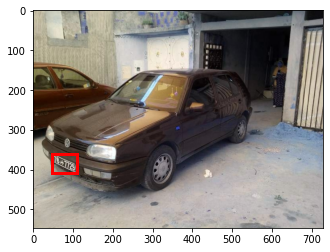

In [8]:
# printing img with bounding box

idx = 122   
img = cv2.imread(lin_dect_update.loc[idx, 'path']) 
bb = ast.literal_eval(lin_dect_update.loc[idx, 'bb'])

plt.imshow(img)
ax = plt.gca()
rect = Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], linewidth=1, edgecolor= 'red', facecolor='none', lw=3)
ax.add_patch(rect)

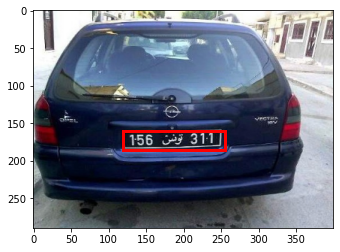

In [11]:
# Resizing image and bounding box

mean = (0.485, 0.456, 0.406) 
std = (0.229, 0.224, 0.225)
size = 300
idx = 150 

img = lin_dect_update.loc[idx, 'path']
bb = ast.literal_eval(lin_dect_update.loc[idx, 'bb'])


image = np.array(Image.open(img))

transform = A.Compose(bbox_params= {'format': 'coco', 'label_fields': ["bbox_classes"] },
                      transforms= [
                                   A.Resize(size, int(1.49 * size)),
                                   A.RandomCrop(290, 400, always_apply=True),
                                   A.RandomCrop(290, 400, always_apply=True),
                      ]
                      )


bbox = [[bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]]
bbox_classes = ['lincense_plate']

transformed = transform(image=image, bboxes = bbox, bbox_classes = bbox_classes)
image = transformed['image']
bb1 = transformed['bboxes'][0]

plt.imshow(image)
ax = plt.gca()
rect1 = Rectangle((bb1[0], bb1[1]), bb1[2], bb1[3], linewidth=1, edgecolor='red', facecolor='none', lw=3)
ax.add_patch(rect1)
         

In [21]:
#config

train_config = {
    'img_size': 300,
    'mean': (0.485, 0.456, 0.406),
    'std': (0.229, 0.224, 0.225),
    'epochs': 5,
    'batch_size': 8,
    'lr': 0.0003,
    'load_checkpoint_dir': 'CNN_checkpoints/checkpoints/cnn_model-sll50-noblur2.pt',
    'checkpoint_dir': 'CNN_checkpoints/checkpoints/cnn_model-sll50-noblur2.pt',
    'load_checkpoint': True,
}


In [14]:

class LinDectDataset(Dataset):
    def __init__(self, paths, bbs, transform_aug):
        self.paths = paths
        self.bbs = bbs
        self.size = size
        mean = (0.485, 0.456, 0.406) 
        std = (0.229, 0.224, 0.225)
        if self.bbs is not None:
            self.transform = A.Compose(bbox_params= {'format': 'coco', 'label_fields': ["bbox_classes"] }, transforms= transform_aug)
        else:
            self.transform = A.Compose(transforms = transform_aug)

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = np.array(Image.open(path))
        except:
            return self[idx+1]

        if self.bbs is not None:
            bb = ast.literal_eval(self.bbs[idx])
            bbox = [[bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]]
            bbox_classes = ['lincense_plate']
            transformed = self.transform(image=img, bboxes = bbox, bbox_classes = bbox_classes)
            try:
                bb1 = transformed['bboxes'][0]
            except:
                return self[idx+1]
            bb1 = torch.tensor(bb1, dtype=torch.long)
         
        else:
            transformed = self.transform(image=img)
            bb1 = torch.tensor([0, 0, 0, 0], dtype=torch.long)
        img = transformed['image']
        img = np.transpose(img, (2, 0, 1)).astype(np.float32) 
        img = torch.tensor(img, dtype=torch.float)

        
        return img, bb1


In [16]:

size = train_config['img_size']
mean = train_config['mean']
std = train_config['std']

train_transforms_aug = [  
                    A.Resize(size, int(1.49 * size)),
                    A.RandomCrop(290, 400, always_apply=True),
                    A.RandomCrop(290, 400, always_apply=True),
                    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p =0.5),
                    A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
]

eval_transforms_aug = [
                   A.Resize(size, int(1.49 * size)),
                   A.RandomCrop(290, 400, always_apply=True),
                   A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p =0.5),
                   A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
]


In [17]:

# model

mod50 = models.resnet50(pretrained = False)
mod50_ftrs = mod50.fc.in_features
mod50.fc = nn.Linear(mod50_ftrs, 4)


In [20]:

def train_batch(model, train_loader, optimizer, device,):
    model.train()
    total_loss = 0
    bar = tqdm(train_loader, total= len(train_loader), desc ='Model training')
    for data in bar:
        imgs, bbs = [d.to(device) for d in data]
        preds = model(imgs)
        loss = F.smooth_l1_loss(preds,bbs, reduction='mean')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(train_loader)


def evaluate(model, valid_loader, device,):
    model.eval()
    total_loss = 0
    total_preds = []
    bar = tqdm(valid_loader, total = len(valid_loader), desc= 'Evaluation')
    with torch.no_grad():
        for data in bar:
            imgs, bbs = [d.to(device) for d in data]
            preds = model(imgs)
    
            loss = F.smooth_l1_loss(preds,bbs, reduction='mean')
            total_loss += loss.item()
            total_preds.append(preds)
    return total_preds, total_loss / len(valid_loader)


def train_aug(train_df, train_transforms_aug, device, model, optimizer,):
    print('-'*10, 'train data aug begins', '-'*10)
    total_aug_loss_lst = []
    for idx_aug, aug in enumerate(train_transforms_aug[2:-1]):
        print(f"Aug: {idx_aug+1}/{len(train_transforms_aug[2:-1])}")
       
        train_transforms = A.Compose(bbox_params= {'format': 'coco', 'label_fields': ["bbox_classes"] },
                            transforms= train_transforms_aug[:2] + [aug] + [train_transforms_aug[-1]])
        train_dataset = LinDectDataset(train_df.loc[:, 'path'].values, train_df.loc[:, 'bb'], train_transforms )
        train_loader = DataLoader(train_dataset, batch_size= train_config['batch_size'], shuffle=True)
        total_aug_loss = train_batch(model, train_loader, optimizer, device)
        total_aug_loss_lst.append(total_aug_loss)
        print(f"Aug {idx_aug+1} Loss: {total_aug_loss}")
    print('-'*10, 'train data aug ends', '-'*10)

    return sum(total_aug_loss_lst)/ len(total_aug_loss_lst)

    

def train_model(train_df, eval_df, train_transforms_aug, eval_transforms_aug):
    epochs = train_config['epochs']
    lr = train_config['lr']
    checkpoint_dir = train_config['checkpoint_dir']
    load_checkpoint_dir = train_config['load_checkpoint_dir']
    load_checkpoint = train_config['load_checkpoint']
    iter = 1
    best_loss = float('inf')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')

    # Eval
    eval_dataset = LinDectDataset(eval_df.loc[:, 'path'].values, eval_df.loc[:, 'bb'], eval_transforms_aug)
    valid_loader = DataLoader(eval_dataset, shuffle=False, batch_size = train_config['batch_size'], drop_last=True)

    # model
    cnn = mod50
    cnn.to(device)
    cnn.train()

    # load checkpoint
    if load_checkpoint:
        print('Loading base checkpoint...')
        checkpoint = torch.load(load_checkpoint_dir, map_location= torch.device('cpu'))
        cnn.load_state_dict(checkpoint['model'])
        best_loss = checkpoint['valid_loss']
        iter = checkpoint['iteration'] + 1
        if 'lr' in checkpoint.keys():
            lr = checkpoint['lr']
            print(f"Current lr: {checkpoint['lr']:.10f}")
        print(f"Loaded base checkpoint, best_valid_loss: {best_loss:.4f}, train_loss: {checkpoint['train_loss']:.4f}, iteration: {checkpoint['iteration']}")

    optimizer = optim.Adam(cnn.parameters(), lr= lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.8, 
                                                     patience=5, verbose = True)  

    for epoch in range(iter, epochs+iter):
        print(f'\nEpoch: {epoch}')
        

        train_loss = train_aug(train_df, train_transforms_aug, device, cnn, optimizer)
        preds, valid_loss = evaluate(model = cnn, valid_loader = valid_loader, device = device)
        
        if valid_loss < best_loss: 
            best_loss = valid_loss
            torch.save({
                    'model': cnn.state_dict(),
                    'train_loss': train_loss,
                    'iteration': epoch,
                    'valid_loss': valid_loss,
                    'lr': optimizer.param_groups[0]['lr'],
            }, os.path.join(train_config['checkpoint_dir']))


        print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Best Valid Loss: {best_loss:.4f}")
        print('-' * 50)
        scheduler.step(valid_loss)
        

In [22]:

train_model(train_samples, valid_samples, train_transforms_aug, eval_transforms_aug)


device: cuda
Loading base checkpoint...
Current lr: 0.0000960000
Loaded base checkpoint, best_valid_loss: 0.5814, train_loss: 0.7121, iteration: 103

Epoch: 104
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 90/90 [00:55<00:00,  1.64it/s]


Aug 1 Loss: 0.7827961030933592
Aug: 2/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.64it/s]


Aug 2 Loss: 0.6970600611633725
Aug: 3/3


Model training: 100%|██████████| 90/90 [00:55<00:00,  1.63it/s]


Aug 3 Loss: 0.7221006287468804
---------- train data aug ends ----------


Evaluation: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]


Epoch: 104, Train Loss: 0.7340, Valid Loss: 0.7459, Best Valid Loss: 0.5814
--------------------------------------------------

Epoch: 105
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.65it/s]


Aug 1 Loss: 0.638709643483162
Aug: 2/3


Model training: 100%|██████████| 90/90 [00:55<00:00,  1.63it/s]


Aug 2 Loss: 0.6995325009028117
Aug: 3/3


Model training: 100%|██████████| 90/90 [00:55<00:00,  1.63it/s]


Aug 3 Loss: 0.708301779296663
---------- train data aug ends ----------


Evaluation: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s]


Epoch: 105, Train Loss: 0.6822, Valid Loss: 0.7024, Best Valid Loss: 0.5814
--------------------------------------------------

Epoch: 106
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.66it/s]


Aug 1 Loss: 0.6114332566658656
Aug: 2/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.64it/s]


Aug 2 Loss: 0.6379413447446294
Aug: 3/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.64it/s]


Aug 3 Loss: 0.6594931234916052
---------- train data aug ends ----------


Evaluation: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s]


Epoch: 106, Train Loss: 0.6363, Valid Loss: 0.9833, Best Valid Loss: 0.5814
--------------------------------------------------

Epoch: 107
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.66it/s]


Aug 1 Loss: 0.6131576071182887
Aug: 2/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.64it/s]


Aug 2 Loss: 0.6429505848222309
Aug: 3/3


Model training: 100%|██████████| 90/90 [00:55<00:00,  1.64it/s]


Aug 3 Loss: 0.7566734376880858
---------- train data aug ends ----------


Evaluation: 100%|██████████| 22/22 [00:05<00:00,  3.75it/s]


Epoch: 107, Train Loss: 0.6709, Valid Loss: 0.6610, Best Valid Loss: 0.5814
--------------------------------------------------

Epoch: 108
---------- train data aug begins ----------
Aug: 1/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.66it/s]


Aug 1 Loss: 0.759077231089274
Aug: 2/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.64it/s]


Aug 2 Loss: 0.7471899577312999
Aug: 3/3


Model training: 100%|██████████| 90/90 [00:54<00:00,  1.64it/s]


Aug 3 Loss: 0.6511802936593691
---------- train data aug ends ----------


Evaluation: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s]

Epoch: 108, Train Loss: 0.7191, Valid Loss: 0.6606, Best Valid Loss: 0.5814
--------------------------------------------------


In [33]:


def predict(path, test_df, eval_transforms_aug, transform=transform):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = mod50
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    m = checkpoint['model']
    model.load_state_dict(m)
    print(f"Loaded base checkpoint, best_valid_loss: {checkpoint['valid_loss']:.4f}, train_loss: {checkpoint['train_loss']:.4f}, iteration: {checkpoint['iteration']}")
    model.to(device)
    model.eval()

    # Dataset
    eval_dataset = LinDectDataset(test_df.loc[:, 'path'].values, None, eval_transforms_aug)
    test_loader = DataLoader(eval_dataset, shuffle=False, batch_size = 1, drop_last=True)


    with torch.no_grad():
        for idx, img_data in enumerate(zip(test_loader, test_df.loc[:, 'path'])):
            data, path = img_data
            imgs, bbs = [d.to(device) for d in data]
            preds = model(imgs)
            pred = preds[0].detach().cpu().numpy().tolist()
            preds = [int(round(i)) for i in pred] # [x1, y1, x2, y2]

            img =transform(image = np.array(Image.open(path)))['image']
            plt.imshow(transforms.ToPILImage()(img))
            ax = plt.gca()
            rect1 = Rectangle((preds[0], preds[1]), preds[2], preds[3], linewidth=1, edgecolor='red', facecolor='none', lw=3)
            ax.add_patch(rect1)
            plt.show()
         
            if idx == 20:
                break
    

Loaded base checkpoint, best_valid_loss: 0.5814, train_loss: 0.7121, iteration: 103


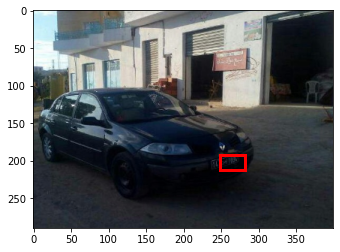

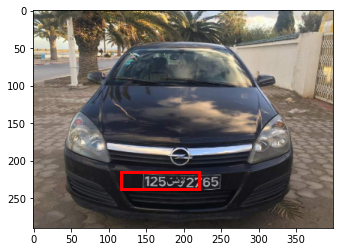

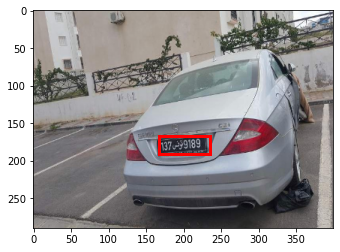

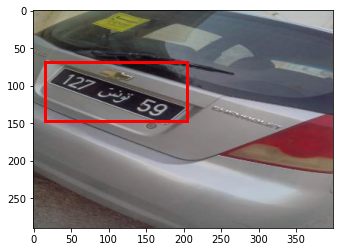

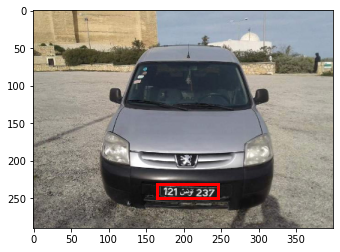

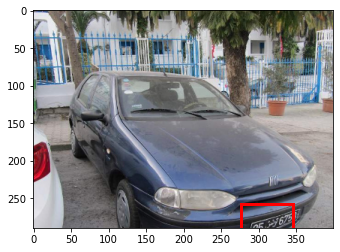

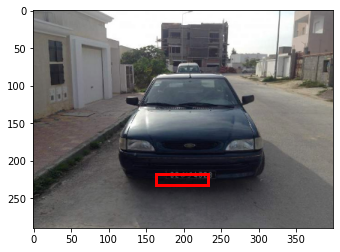

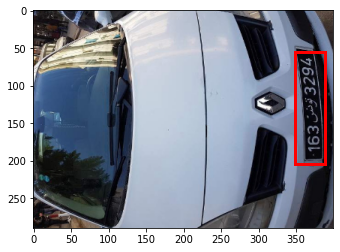

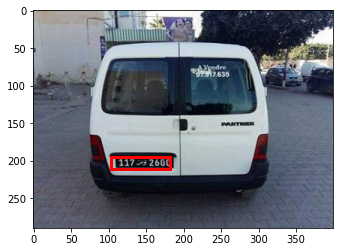

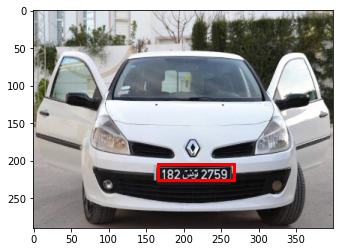

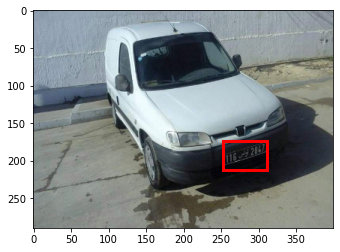

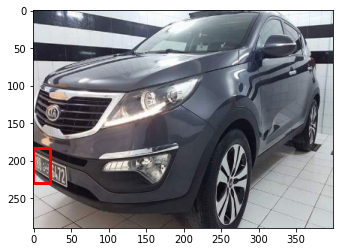

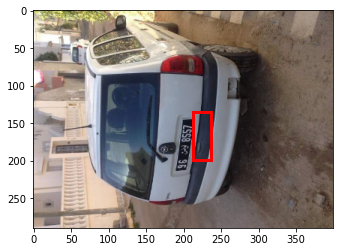

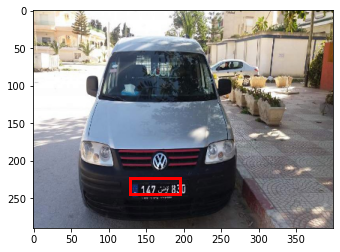

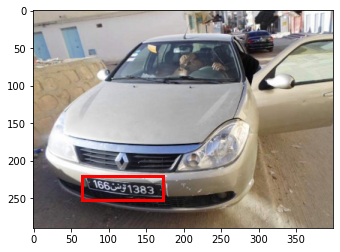

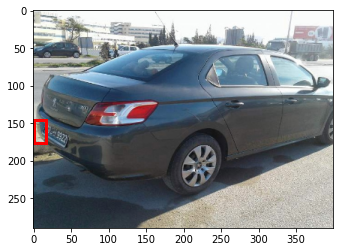

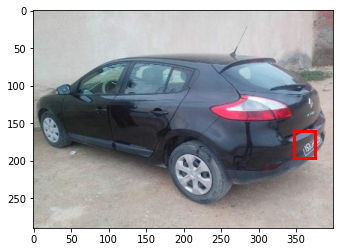

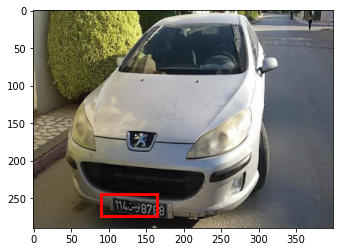

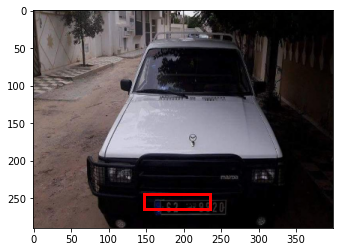

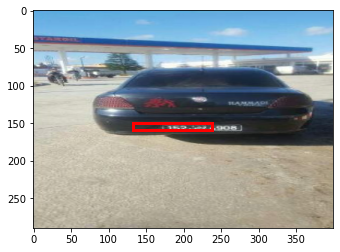

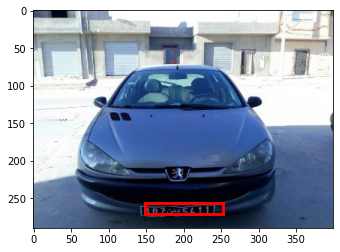

In [35]:

transform = A.Compose(
                      transforms= [
                                   A.Resize(size, int(1.49 * size)),
                                   A.RandomCrop(290, 400, always_apply=True),
                                   A.RandomCrop(290, 400, always_apply=True),
                      ]
                      )

path = train_config['checkpoint_dir']

predict(path, train_samples, eval_transforms_aug, transform=transform)
